In [1]:
import numpy as np
import matplotlib.pyplot as  plt
from tqdm import tqdm

from np_fun import prob, prob_part
#from tf_fun import init as tf_init
from Annealing import Annealer

%load_ext autoreload 
%autoreload 2

In [2]:
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]

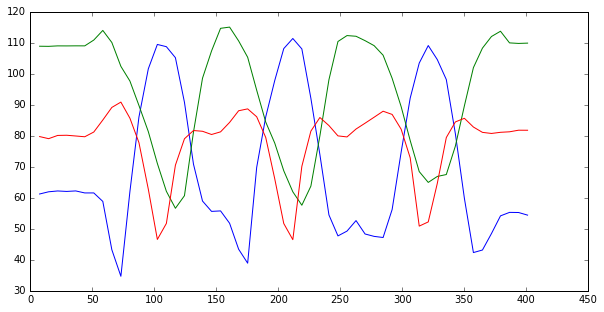

In [3]:
from numpy import genfromtxt
filenames = [
    './data_05-07-2018_20-20_port0.csv',
    './data_05-07-2018_20-30_port1.csv',
    './data_05-07-2018_20-20_port2.csv'
]
exp_points = [genfromtxt(i, delimiter=',') for i in filenames]
times = exp_points[0].T[1]
exp_points = np.array([i.T[0] for i in exp_points])
# plot the data
plt.figure(figsize=(10,5))
for i in exp_points:
    plt.plot(times,i)

### period is approx 120 sec, ampl 110-40=70, mean min is 43

Data points used: 35


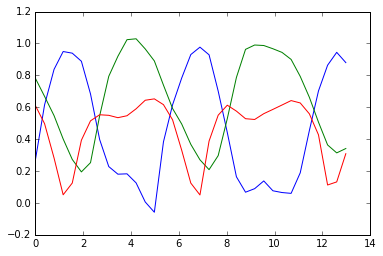

In [4]:
me_min, ampl, per = 43, 110-40, 120
start_exp, end_exp = 10, 45
data = exp_points[:, start_exp:end_exp]
pts = times[start_exp:end_exp]-times[start_exp]

data = data - me_min
data /= ampl 
pts = pts/120*2*np.pi
for i in data:
    plt.plot(pts,i)
l = len(pts)
print('Data points used:',l)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.31465563, 0.24709717, 0.20324922, 0.19665199, 0.23199671,
        0.31405167, 0.44190499, 0.60334649, 0.77455768, 0.92190598,
        1.        , 0.92190598, 0.77455768, 0.60334649, 0.44190499,
        0.31405167, 0.23199671, 0.19665199, 0.20324922, 0.24709717,
        0.31465563]),
 <matplotlib.lines.Line2D at 0x7f0a859b47b8>)

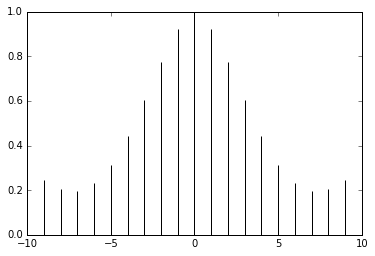

In [5]:
plt.acorr(data[0])

[ 0.          0.07503429  0.15006857  0.22510286  0.30013714  0.37517143
  0.45020572  0.52524     0.60027429  0.67530858  0.75034286  0.82537715
  0.90041143  0.97544572  1.05048001  1.12551429  1.20054858  1.27558287
 -1.27558287 -1.20054858 -1.12551429 -1.05048001 -0.97544572 -0.90041143
 -0.82537715 -0.75034286 -0.67530858 -0.60027429 -0.52524    -0.45020572
 -0.37517143 -0.30013714 -0.22510286 -0.15006857 -0.07503429]


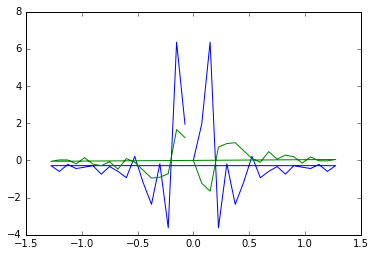

In [6]:
ft = np.fft.fft(data[0]-np.mean(data[0]))
freq = np.fft.fftfreq(ft.shape[-1],d=pts[1])
plt.plot(freq,ft.real)
plt.plot(freq,ft.imag)
print(freq)

120 11.668611435239207


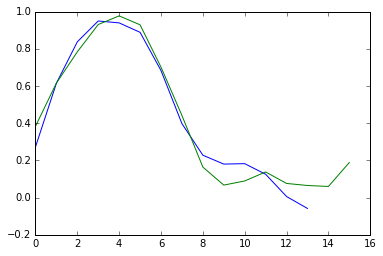

In [7]:
#### per = 1/0.15006
units_period = 1/0.0857
print(per,units_period)
plt.plot(data[0][:14])
plt.plot(data[0][14:30])


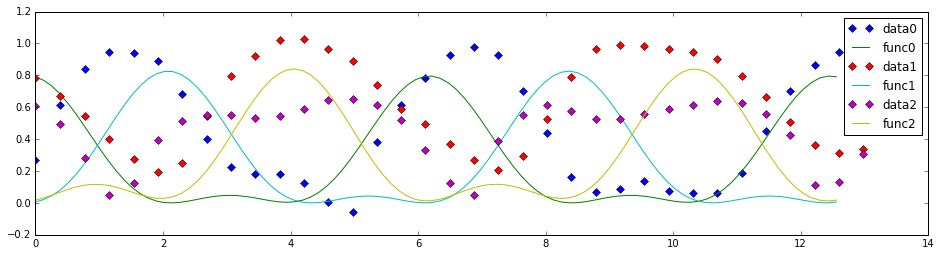

In [8]:
def func(x):
    return np.abs(np.square(prob_part(0,0,0,0,phi=x)))
def plot3(func,on_same=False):
    lin,d = sampl(func,0,12.56,100)
    d = np.array(d).T
    %matplotlib inline
    fs=(16,4)
    if on_same:
        plt.figure(figsize=fs)
        ax =[plt,plt,plt]
    else:
        f,ax = plt.subplots(1,3,figsize=fs,sharey=True)
    for i in range(3):
        ax[i].plot(pts,data[i],'D',label='data%i'%i)
        ax[i].plot(lin,d[i],label='func%i'%i)
    plt.legend()
        
plot3(func,on_same=True)

In [9]:
fixed = [0,0]
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl_map_depr = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),f(np.linspace(fm,to,cnt))]
np_map = lambda f,x: np.array(list(map(f, x)))

device = lambda z,x:np.abs(np.square(prob_part(z[0],z[1],fixed[0],fixed[1],phi=x)))
unit = lambda z,x: device(z,x).dot(np.array([0,1,0]).T)
cost = lambda f,data,points=pts: np.sum(np.square(f(points).T-data))
foo = lambda x: unit([0,0],x)

ttt = carr(unit,[0,0])
print(np_map(ttt,pts))
cost(carr(device,[0,0]),data,pts)


[6.45591224e-03 7.86564957e-02 2.49524750e-01 4.74975989e-01
 6.88865384e-01 8.14051951e-01 8.01399347e-01 6.56082511e-01
 4.34206631e-01 2.14414239e-01 6.37662708e-02 3.24358986e-03
 1.02451567e-02 3.62956565e-02 4.10657846e-02 1.83899933e-02
 1.34068478e-04 3.58149322e-02 1.60078642e-01 3.64022838e-01
 5.93566476e-01 7.69571953e-01 8.25711322e-01 7.39766782e-01
 5.44638107e-01 3.14497246e-01 1.24811257e-01 2.13344589e-02
 1.31016077e-03 2.45462133e-02 4.28046452e-02 3.13750015e-02
 5.20474439e-03 9.13481285e-03 8.87843234e-02]


19.535176653546973

In [10]:
def get_parametric(func,dots=50):
    xrange = np.linspace(-7.0, 7.0, dots)
    yrange = np.linspace(-7.0, 7.0, dots)
    p = np.zeros((len(xrange),len(yrange)))
    f2d = lambda x,y:cost(carr(func,[x,y]),data)
    #f2d = lambda x,y:opt.prob(x,y,12)
    for x in tqdm(range(len(xrange))):
        for y in range(len(yrange)):
            p[y,x] =  f2d(xrange[x],yrange[y])
    return xrange,yrange,p

def display_parametric(p):
    best_pos=np.unravel_index( np.argmin(p),p.shape)
    best_pos = [xrange[best_pos[0]], yrange[best_pos[1]]]
    print("Min cost is:",np.min(p),' at position ',best_pos)
    
    %matplotlib notebook
    plt.contourf(xrange,yrange,p,100)
    #plt.savefig('fig.png',dpi=300)
xrange,yrange,p = get_parametric(device)
print()

100%|██████████| 50/50 [00:02<00:00, 20.59it/s]

In [11]:
best_pos=np.unravel_index( np.argmin(p),p.shape)
best_pos = [xrange[best_pos[1]], yrange[best_pos[0]]]
print("Min cost is:",np.min(p),' at position ',best_pos)

Min cost is: 13.701057777434606  at position  [-1.8571428571428577, 5.857142857142856]


/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


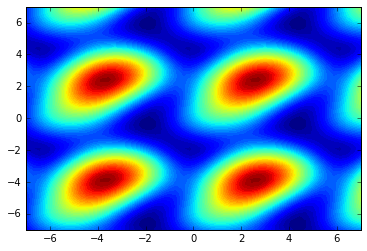

In [12]:

%matplotlib inline
plt.contourf(xrange,yrange,p,50)

#plt.scatter(*np.array(opt.dots).T,c=np.arange(len(opt.dots)),marker='o',alpha=0.7)
#plt.savefig('fig.png',dpi=300)

cost is  13.701057777434606


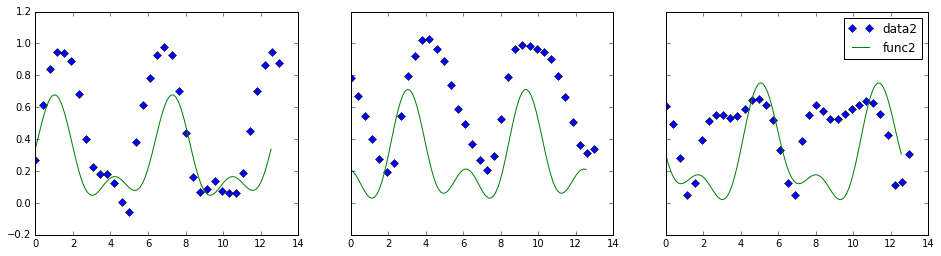

In [13]:

point = [-0.5,2.52]
point = best_pos
fun = carr(device,point)
print('cost is ',cost(fun,data))
plot3(fun)
#plt.figure(figsize=(15,5))
#plt.plot(pts,data[1],'D')
#plt.plot(*sampl(carr(unit,point),0,14))

cost 19.535176653546973


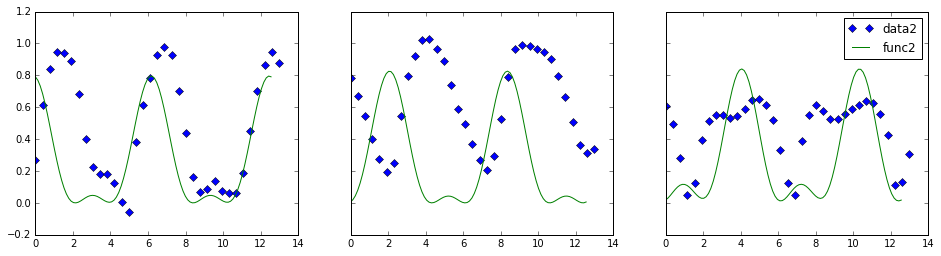

In [14]:
kek = carr(device,[0,0])
carr_dev = lambda x,y:carr(device,[x,y])
print("cost",cost(carr_dev(0,0),data))
plot3(kek)

plt.savefig('./figs/unfitted_cost19.5.eps')

[[0.1 0.  0.5]
 [0.1 0.  0.5]]
cost 27.387343636451675
sumsq: 37.55921332216596


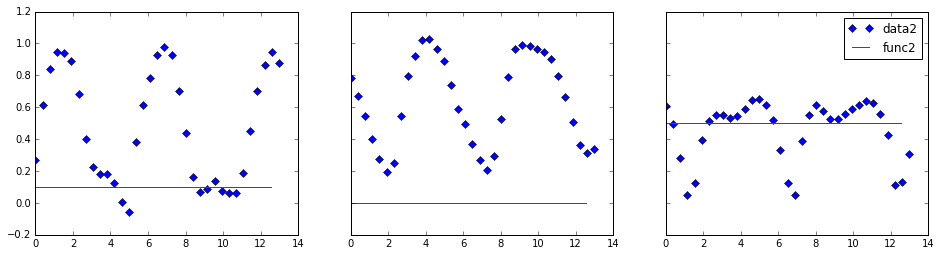

In [15]:

func = lambda x: np.array([0.1,0,0.5]*len(x)).reshape(len(x),3)

print(func(np.array([2,3])))
print("cost",cost(func,data))
t_data = data[:,:]
#t_data[2,:]-=0.5
print("sumsq:",np.sum(np.square(data)))
plot3(func)


### Optimisation


In [94]:
unit_all = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T*z[6]+z[7]
opt = Annealer(unit_all,points_data=(pts,data),energy=3)

In [95]:
start = [0,0,0,0,-1,0,1,0]
#start = [-25.648831,   -16.91017209, -10.20137638 , 11.01714674, 1.12643974, -6.81656814,3.31360078,-0.39924749]
start = best_point
#[0,0,0,0,-1,0,1,0]
#start = [0,0,0,0,-1,60,1.5,0]
scales= np.array([1,1,1,1,0.2,1.5,0.4,0.3])*1
point,cost = opt.opt(start_point=start,
                     scales = scales,
                     max_steps =10000
                    )

print(point,cost)
print(opt.best)

 99%|█████████▉| 9924/10000 [00:12<00:00, 820.76it/s]/home/danlkv/quantTechLab/Fit/Annealing.py:19: RuntimeWarning: overflow encountered in exp
  
100%|██████████| 10000/10000 [00:12<00:00, 820.69it/s]

[ -3.93875073  10.31137219   6.72059424 -27.66908593   0.98513977
 -47.82819059   0.37576794   0.46623253] 22.995124355311873
[  2.31877906  -9.38742285  -6.29417348   4.92660025   1.15250211
 -10.88331248   1.09990824   0.11194721]


16.6644663677865


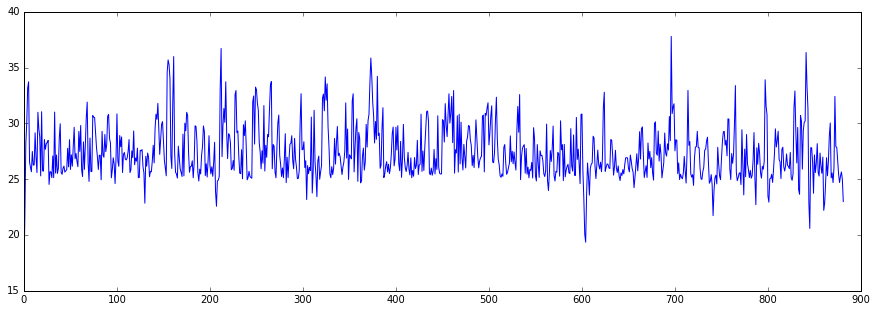

In [96]:
plt.figure(figsize=(15,5))
plt.plot(opt.costs)
print(np.min(opt.costs))

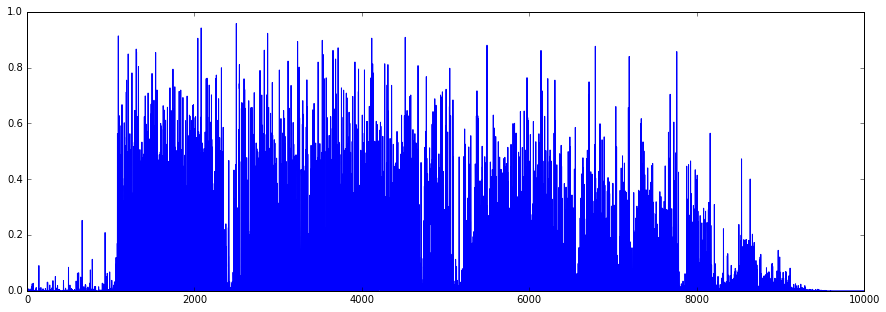

In [97]:

plt.figure(figsize=(15,5))
plt.plot(opt.probs)

16.6644663677865


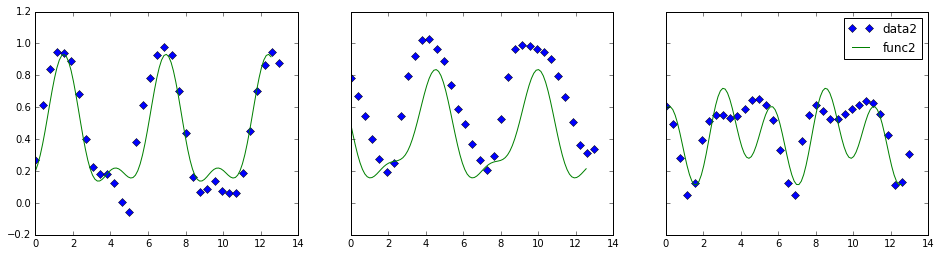

In [98]:
%matplotlib inline
best_fun= carr(unit_all,opt.best)
print(opt.cost(best_fun))
plot3(lambda x: best_fun(x).T)
plt.savefig('figs/fitted_cost1.7.eps')


2.7140754692104787


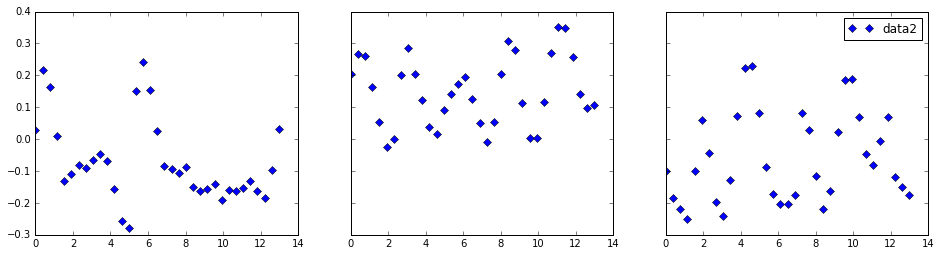

In [88]:
#lin,d = sampl(func,0,12.56,100)
#d = np.array(d).T
f = best_fun(pts)
%matplotlib inline
fs=(16,4)
print(np.sum(np.square(data - f)))
fig,ax = plt.subplots(1,3,figsize=fs,sharey=True)
for i in range(3):
    ax[i].plot(pts, data[i]-f[i],'D',label='data%i'%i)
plt.legend()
best_point = opt.best

In [83]:
print(best_point)


[  5.1141269   -7.2592076   -6.26240802   2.67841306   1.12656652
 -12.58262674   0.8497118    0.37352067]
